In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from collections import Counter
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from PIL import Image
import os
import shutil

In [3]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jangedoo/utkface-new

##unzip and delete remnant zip file
# !unzip content\*.zip && rm *.zip

from zipfile import ZipFile
file_name= r'/content/utkface-new.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  !rm *.zip
  print('Done')

shutil.rmtree('/content/crop_part1')
shutil.rmtree('/content/utkface_aligned_cropped')

Saving kaggle.json to kaggle.json
 97% 322M/331M [00:01<00:00, 225MB/s]
100% 331M/331M [00:01<00:00, 207MB/s]
Done


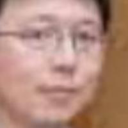

In [4]:
im =Image.open('/content/UTKFace/38_0_2_20170116232740686.jpg.chip.jpg').resize((128, 128))
im

In [5]:
def preprocess_data(data_dir):
  data = os.listdir(data_dir)
  print(f'There are {len(data)} images')
  shuffle(data)
  classes = [int(i.split('_')[1]) for i in data]
  # convert images to vector
  data_ =[]
  for file in data:
    face = plt.imread(f'{data_dir}/{file}')
    face = cv2.resize(face, (128, 128) )
    data_.append(face)
  #normalize data
  data_= np.array(data_).astype('float32')/255

  #sort into training and validation sets
  (x_train, y_train), (x_test, y_test) = (data_[:23000],classes[:23000]) , (data_[23000:] , classes[23000:])

  assert len(x_train)+len(x_test)== len(data_), "Something is amiss"

  return (data_, classes), (x_train, y_train), (x_test, y_test)

def feature_extractor(inputs):
  feature_extractor = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')(inputs)
  return feature_extractor

def classifier(inputs):
    x = MaxPooling2D()(inputs)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(1, activation="sigmoid", name="classification")(x)
    return x

def final_model(inputs):
  resnet_feature_extractor = feature_extractor(inputs)
  classification_output = classifier(resnet_feature_extractor)
  return classification_output

def define_compile_model():
  inputs = Input(shape=(128, 128,3))
  classification_output = final_model(inputs) 
  model = Model(inputs=inputs, outputs = classification_output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
  return model


def cont_training(file_dir, epoch):
  model = define_compile_model()
  latest= tf.train.latest_checkpoint(file_dir)
  model.load_weights(latest)
  details = model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=epoch,
                                verbose=1, callbacks= [early, check])
  return model

def test_pred(img_url):
  image_ = np.expand_dims(Image.open(img_url).resize(size=(128, 128)), axis=0)
  p_ = model.predict(image_)
  class_ = "Male" if p_ < 0.5 else 'Female'
  return class_

In [6]:
(data_, classes), (x_train, y_train), (x_test, y_test)= preprocess_data('/content/UTKFace')

There are 23708 images


In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
train_datagen= ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True, validation_split=0.2)
valid_datagen= ImageDataGenerator()


train_datagen.fit(x_train)
train_gen= train_datagen.flow(x= x_train, y= y_train, subset='training', batch_size= 32)
valid_gen= train_datagen.flow(x= x_train, y= y_train, subset= 'validation', batch_size= 32)

In [9]:
file_dir= r'/content/drive/MyDrive/Gender Detection/info/'
file_path= r'/content/drive/MyDrive/Gender Detection/info/weights.{epoch:02d}-{val_accuracy:.2f}.ckpt'
# os.makedirs(file_dir)
check= ModelCheckpoint(file_path, save_freq= 'epoch',period= 2, save_weights_only= True, verbose= 1,)
early= EarlyStopping(monitor= 'val_accuracy', patience= 3, mode= 'max')

In [20]:
model = define_compile_model()
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2621952   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
______________________________________________________________

In [30]:
details= model.fit_generator(generator= train_gen, validation_data=valid_gen, epochs= 10, verbose= 1,
                             callbacks= [check, early])

#model.fit(x_train, y_train,batch_size=64,epochs=35, validation_data=(x_valid, y_valid),)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
575/575 [==============================] - 91s 158ms/step - loss: 0.2563 - accuracy: 0.8903 - val_loss: 1.4097 - val_accuracy: 0.7241
Epoch 2/10
575/575 [==============================] - 90s 157ms/step - loss: 0.2443 - accuracy: 0.8953 - val_loss: 1.0436 - val_accuracy: 0.6107

Epoch 00002: saving model to /content/drive/MyDrive/Gender Detection/info/weights.02-0.61.ckpt
Epoch 3/10
575/575 [==============================] - 89s 156ms/step - loss: 0.2337 - accuracy: 0.9011 - val_loss: 0.7046 - val_accuracy: 0.8446
Epoch 4/10
575/575 [==============================] - 90s 156ms/step - loss: 0.2270 - accuracy: 0.9041 - val_loss: 0.4186 - val_accuracy: 0.8850

Epoch 00004: saving model to /content/drive/MyDrive/Gender Detection/info/weights.04-0.88.ckpt
Epoch 5/10
575/575 [==============================] - 89s 154ms/step - loss: 0.2183 - accuracy: 0.9105 - val_loss: 0.4250 - val_accuracy: 0.8746
Epoch 6/10
575/575 [==============================] - 89s 154ms/step - loss: 0.2099

In [ ]:
## continue training
# model= cont_training(file_dir, epoch= 6)

In [48]:
model.save(r'/content/drive/MyDrive/Gender Detection/gender_detection.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [31]:
# Evaluate the model on test set
score = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8785310983657837


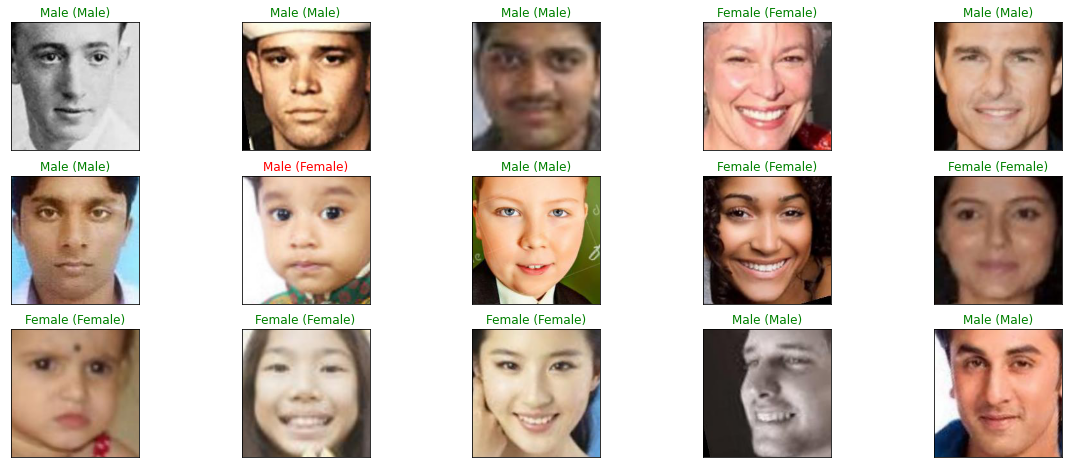

In [38]:
#test on images from the test set
y_hat = model.predict(x_test)
labels= ['Male', 'Female']

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = 0 if y_hat[index] < 0.5 else 1
    true_index =y_test[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], labels[true_index]), 
                 color=("green" if predict_index == true_index else "red"))
plt.show()


In [ ]:
# model_= load_model('/content/drive/MyDrive/Gender Detection/gender_detection.h5')

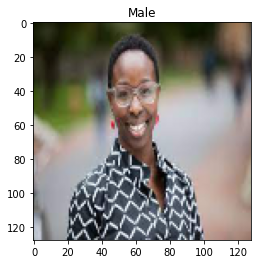

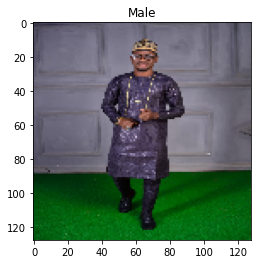

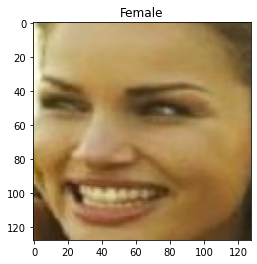

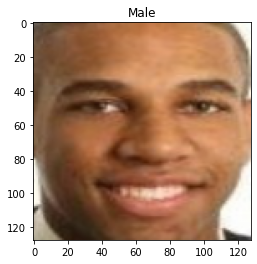

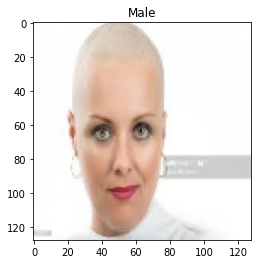

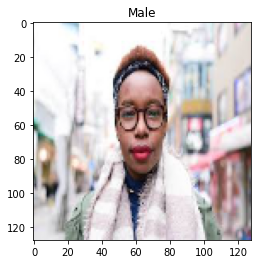

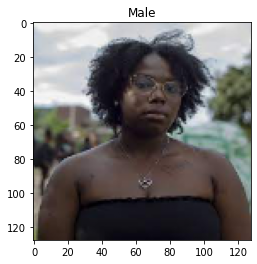

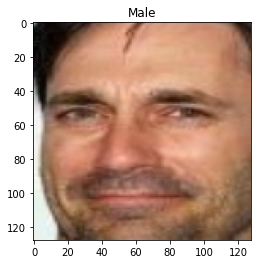

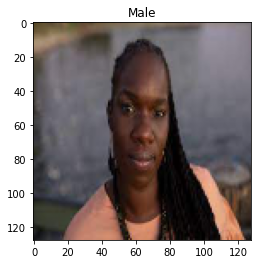

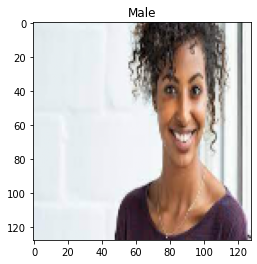

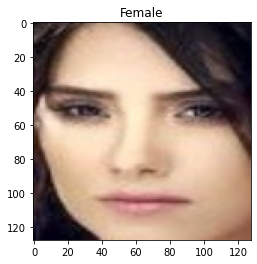

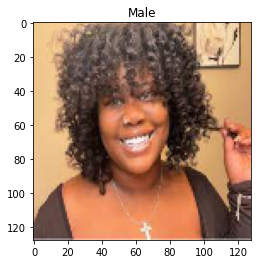

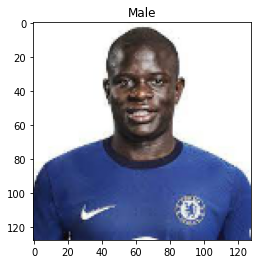

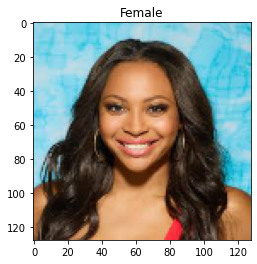

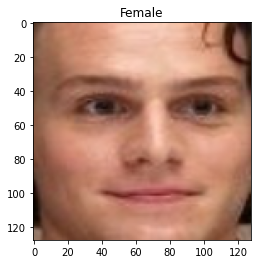

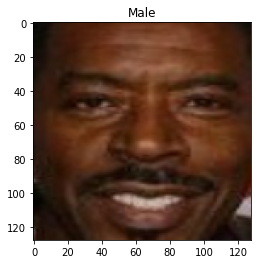

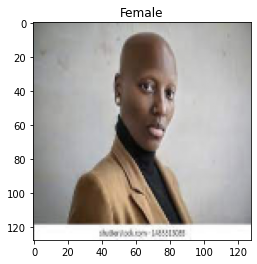

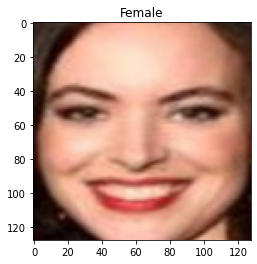

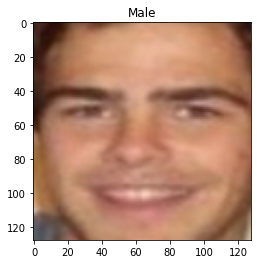

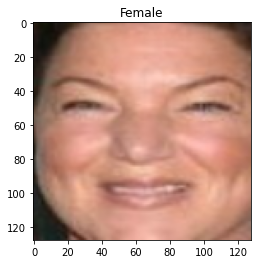

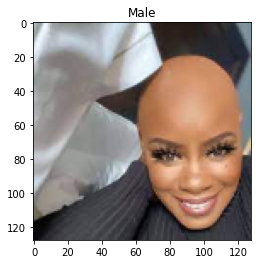

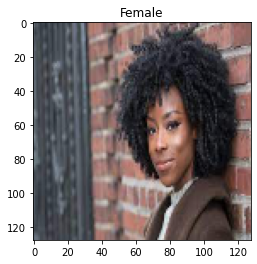

In [17]:
# test on random pics
# from google.colab import files
# files.upload()

lst= ['black_3.jfif',
 'IMG-20210522-WA0004.jpg',
 '112961.jpg.jpg',
 '063558.jpg.jpg',
 '6.jfif',
 'black_5.jfif',
 'black_2.jfif',
 '063539.jpg.jpg',
 'black_1.jfif',
 '1.jfif',
 '112944.jpg.jpg',
 '4.jfif',
 'kante.jfif',
 '3.jfif',
 '063592.jpg.jpg',
 '063518.jpg.jpg',
 'bald1.jfif',
 '131506.jpg.jpg',
 '063479.jpg.jpg',
 '112987.jpg.jpg',
 'bald2.jfif',
 '2.jfif']
# from google.colab import files
# files.upload()

for i in lst:
  img_url= f'/content/{i}'
  image_ = plt.imread(img_url)
  image = cv2.resize(image_, (128, 128))/255
  p_ = model_.predict(np.expand_dims(image, axis= 0))
  plt.imshow(image)
  class_= 'Male' if p_ < 0.3 else 'Female'
  plt.title(f'{class_}')
  plt.show()